## Домашняя работа №5
**Тема: линейные модели и честный ML-эксперимент (логистическая регрессия, бейзлайн, метрики).**

#### 1. Загрузка датасета из `S05-hw-dataset.csv` и первичный анализ данных

Импортируем необходимые библиотеки

In [135]:
# Для работы с данными
import pandas as pd
# Для графиков
import matplotlib.pyplot as plt
# Библиотека sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Метрики
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)


RANDOM_STATE = 39  # начало генератора случайных чисел для воспроизводимости результата
MAX_ITER = 5000  # максимальное число итераций для логистической регрессии
C_VALUES = [0.001, 0.01, 0.1, 1.0, 10.0]  # для подбора гиперпараметра (сила регуляризации)

Загрузим данные из учебного .csv файла

In [136]:
dataSet = pd.read_csv(filepath_or_buffer="S05-hw-dataset.csv", sep=",")  # читает csv по пути к файлу или URL, возвращает DataFrame
dataSet.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


Информация о столбцах датасета

In [137]:
dataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

Базовая описательная статистика каждого из столбцов учебного датасета

In [138]:
dataSet.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


Распределение целевого признака `default` в процентах

In [139]:
dataSet['default'].value_counts(normalize=True)

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

##### Выводы
Учебный датасет содержит 3000 строк (объектов) и 17 столбцов (признаков). Все столбцы заполнены полностью (нет пропусков). Большинство признаков — целочисленные (int64), два — вещественные (float64). Явные аномалии не выявлены.
Таргет несбалансирован: дефолт (1) 41%, нет дефолта (0) 59%.

#### 2. Подготовка таргета и признаков

Выделим матрицу признаков `X` и вектор таргета `y`. В качестве признаков используем все столбцы исходного датасета, кроме таргета (`default`) и идентификатора клиента (`client_id`).

In [140]:
X = dataSet.drop(columns=["client_id", "default"])  # матрица признаков
y = dataSet["default"]  # вектор таргета
print("Матрица признаков: ")
display(X.head())
print("Вектор таргета: ")
display(y.head())

Матрица признаков: 


,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


Вектор таргета: 


0    0
1    0
2    0
3    1
4    1
Name: default, dtype: int64

Проверим типы признаков

In [141]:
print("Типы каждого из признаков: ")
display(X.dtypes)
if all([dtype in ["int64", "float64"] for dtype in X.dtypes]):
    print("Все признаки являются числовыми")
else:
    print("Найдены нечисловые признаки!")

Типы каждого из признаков: 


age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

Все признаки являются числовыми


#### 3. Train/Test-сплит и бейзлайн-модель

Разделим данные на обучающие и тестовые выборки

In [142]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X,  # матрица признаков
    y,  # вектор таргета
    test_size=0.2,  # соотношение тестовых данных
    stratify=y,  # сохраняет пропорции классов в выборках
    random_state=RANDOM_STATE,  #  фиксирует распределение для воспроизводимости
    )

# Разделим обучающие данные на train и validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,      # 0.25 от X_temp = 0.25 * 0.8 = 0.2 от исходных
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print("Размеры выборок:")
print(" - train:", X_train.shape)
print(" - val:  ", X_val.shape)
print(" - test: ", X_test.shape)

# Итого: 20% на test, 20% на val, 60% на train

print("Распределение классов (train):")
print(y_train.value_counts(normalize=True))

print("Распределение классов (val):")
print(y_val.value_counts(normalize=True))

print("Распределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
 - train: (1800, 15)
 - val:   (600, 15)
 - test:  (600, 15)
Распределение классов (train):
default
0    0.589444
1    0.410556
Name: proportion, dtype: float64
Распределение классов (val):
default
0    0.59
1    0.41
Name: proportion, dtype: float64
Распределение классов (test):
default
0    0.59
1    0.41
Name: proportion, dtype: float64


##### Бейзлайн-модель DummyClassifier

Построим **бейзлайн-модель** на основе `DummyClassifier`, используя стратегию `strategy="most_frequent"` и обучим ее на обучающей выборке X_train

In [143]:
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)  # присваивает самый часто встречающийся класс для таргета
baseline.fit(X_train, y_train)
pass

##### Вычислим рассматриваемые метрики (основываясь на validation выборке):

- Точность (аккуратность) - число правильных предсказаний среди всех предсказаний модели

`Accuracy` = (TP + TN) / (TP + TN + FP + FN)

- Точность - показывает, какая доля объектов, предсказанных моделью как положительные, действительно являются положительными

`Precision` = TP / (TP + FP)

- Полнота - показывает, какая доля положительных объектов была верно идентифицирована моделью

`Recall` = TP / (TP + FN)

- F1-score - гармоническое среднее между Precision и Recall, позволяющее сбалансировать их значения

`F1` = 2 * (Precision * Recall) / (Precision + Recall)

- `ROC-AUC` (Area Under the Receiver Operating Characteristic Curve) - площадь под кривой ошибок, которая оценивает способность модели ранжировать объекты

- ROC-кривая показывает, как меняется качество модели при разных порогах отсечения:
  - по оси X – False Positive Rate (ложные срабатывания),
  - по оси Y – True Positive Rate (чувствительность / полнота).

'Метрики качества модели на выборке validation'

'Accuracy: 0.59'

'Precision: 0.0'

'Recall: 0.0'

'F1-score: 0.0'

'ROC-AUC: 0.5'

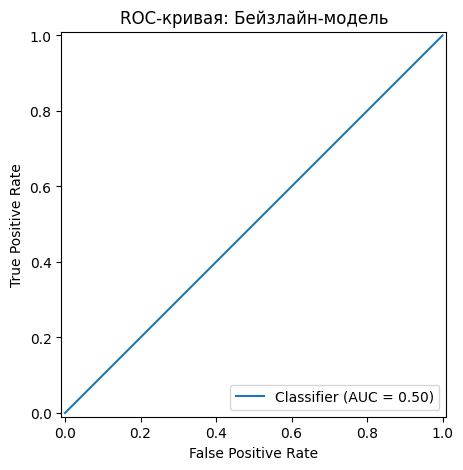

In [144]:
# Получаем предсказания (таргет 0/1) на выборке validation
y_val_baseline_prediction = baseline.predict(X_val)
# Получаем вероятности дефолта (таргет равный 1) на выборке validation
y_val_baseline_proba = baseline.predict_proba(X_val)[:, 1]

display("Метрики качества модели на выборке validation")
display(f"Accuracy: {accuracy_score(y_val, y_val_baseline_prediction)}")
display(f"Precision: {precision_score(y_val, y_val_baseline_prediction, zero_division=0.0)}")
display(f"Recall: {recall_score(y_val, y_val_baseline_prediction, zero_division=0.0)}")
display(f"F1-score: {f1_score(y_val, y_val_baseline_prediction, zero_division=0.0)}")
display(f"ROC-AUC: {roc_auc_score(y_val, y_val_baseline_proba)}")



fig, ax = plt.subplots(figsize=(10, 5))

rocCurve = RocCurveDisplay.from_predictions(
    y_val,
    y_val_baseline_proba,
    ax=ax,
)

ax.set_title("ROC-кривая: Бейзлайн-модель")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
pass

fig.savefig("./figures/baseline_roc_curve.png")



##### Вывод на основе полученных значений метрик

Бейзлайн-модель `DummyClassifier` демонстрирует поведение стратегии `"most_frequent"`, предсказывая наиболее частый исход. Поэтому аккуратность (`accuracy = 0.59`) совпадает с распределением классов (у 59% объектов значение таргета равно 0). При этом все метрики с предсказанием значения таргета 1 равны 0 (`precision`, `recall`, `f1-score`). `ROC-AUC` бейзлайн-модели составляет 0.5, что соответствует случайному угадыванию. Это означает, что модель абсолютно не способна отличать клиентов с дефолтом от клиентов без дефолта.

Наличие базовой модели (бейзлайна) необходимо для определения минимальной планки качества. Любая серьезная модель обязана показывать результат выше этого уровня. Если же наши алгоритмы работают не лучше обычного угадывания или выбора самого частого ответа, значит, они не находят в данных никаких реальных связей. В таком случае использовать такую модель просто нет смысла.

#### 4.  Логистическая регрессия и подбор гиперпараметров

Построим пайплайн для логистической регрессии

In [145]:
pipe = Pipeline([
    # Масштабирование признаков (так как числовые признаки принадлежат разным промежуткам, напр: 0-1; 15 000-20 000; ...)
    ("scaler", StandardScaler()),
    # Логистическая регрессия
    ("logreg", LogisticRegression(
        max_iter=MAX_ITER,  # Максимальное число итераций (для оптимизации)
        random_state=RANDOM_STATE,  # Для воспроизводимости результата
        solver="liblinear",         # Алгоритм оптимизации
    ))
])


Выполним подбор гиперпараметра `C` с помощью обычного перебора

In [146]:
results = []  # список для хранения результатов подбора

for C in C_VALUES:
    current_model = pipe.set_params(logreg__C=C)  # Устанавливаем гиперпараметр
    current_model.fit(X_train, y_train)  # Обучаем на обучающих данных

    y_val_current_prediction = current_model.predict(X_val)  # Вычисляем предсказания на выборке валидации
    y_val_current_proba = current_model.predict_proba(X_val)[:, 1]  # Вычисляем вероятность положительного класса (таргет = 1)

    # Вычисляем метрики
    accuracy = accuracy_score(y_val, y_val_current_prediction)
    precision = precision_score(y_val, y_val_current_prediction)
    recall = recall_score(y_val, y_val_current_prediction)
    f1 = f1_score(y_val, y_val_current_prediction)
    roc_auc = roc_auc_score(y_val, y_val_current_proba)

    # Сохраняем результаты
    results.append({
        'C': C,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'model': current_model
    })

results_df = pd.DataFrame(results)  # Сохраняем результаты перебора гиперпараметра в pandas.DataFrame
results_df = results_df.sort_values(["ROC-AUC"], ascending=False)  # Сортируем по метрике ROC-AUC по убыванию
display(results_df)

,C,Accuracy,Precision,Recall,F1,ROC-AUC,model
2,0.100,0.795000,0.775785,0.703252,0.737740,0.873100,"(StandardScaler(), LogisticRegression(C=10.0, ..."
3,1.000,0.796667,0.776786,0.707317,0.740426,0.873054,"(StandardScaler(), LogisticRegression(C=10.0, ..."
4,10.000,0.796667,0.776786,0.707317,0.740426,0.873042,"(StandardScaler(), LogisticRegression(C=10.0, ..."
1,0.010,0.800000,0.786364,0.703252,0.742489,0.872755,"(StandardScaler(), LogisticRegression(C=10.0, ..."
0,0.001,0.796667,0.784404,0.695122,0.737069,0.871767,"(StandardScaler(), LogisticRegression(C=10.0, ..."


Выделим наилучшую модель по `ROC-AUC`

In [147]:
best_result_idx = results_df['ROC-AUC'].idxmax()
best_model = results_df.loc[best_result_idx, 'model']

print(f"\nЛУЧШАЯ МОДЕЛЬ:")
print(f"Параметр C: {results_df.loc[best_result_idx, "C"]}")
print(f"ROC-AUC на валидации: {results_df.loc[best_result_idx, 'ROC-AUC']}")
print(f"F1-score на валидации: {results_df.loc[best_result_idx, 'F1']}")


ЛУЧШАЯ МОДЕЛЬ:
Параметр C: 0.1
ROC-AUC на валидации: 0.8730995360801064
F1-score на валидации: 0.7377398720682303


Построим графики `PR-curve` и `ROC-curve` для лучшей модели на валидационной выборке

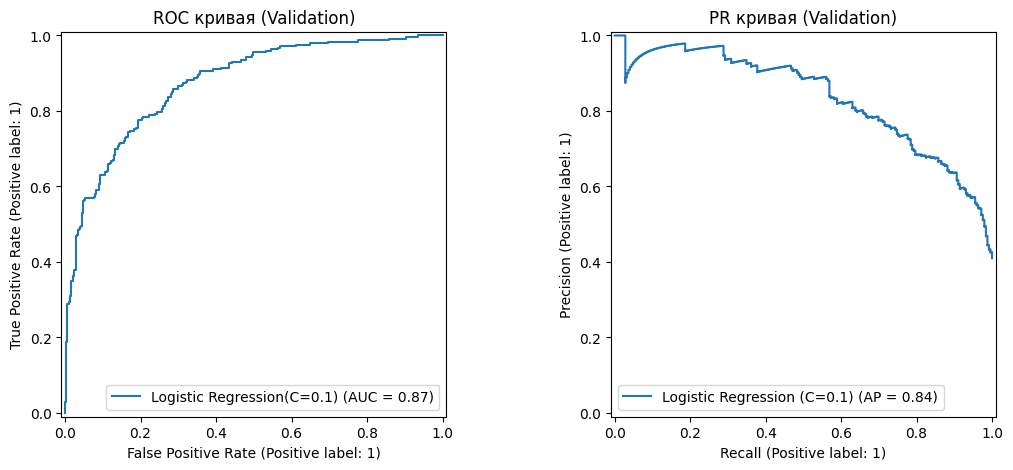

In [148]:
y_val_best_pred = best_model.predict(X_val)
y_val_best_proba = best_model.predict_proba(X_val)[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.set_title(f"ROC кривая (Validation)")
bestRocCurveOnVal = RocCurveDisplay.from_predictions(
    y_val,
    y_val_best_proba,
    ax=ax1,
    name=f'Logistic Regression(C={results_df.loc[best_result_idx, "C"]})'
)

bestPRCurveOnVal = PrecisionRecallDisplay.from_predictions(
    y_val,
    y_val_best_proba,
    ax=ax2,
    name=f'Logistic Regression (C={results_df.loc[best_result_idx, "C"]})'
)
ax2.set_title(f"PR кривая (Validation)")
fig.savefig("./figures/best_model_roc_pr_curves.png")


#### 5. Сводные результаты по модели, основанной на логистической регрессии, и бейзлайн модели

Выполним для моделей предсказания и оценки метрик на `X_test, y_test` выборках

In [149]:
test_results = {}

for model in [baseline, best_model]:
    test_results.setdefault("model_names", []).append(type(model).__name__)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    test_results.setdefault('Accuracy', []).append(accuracy_score(y_test, y_pred))
    test_results.setdefault('Precision', []).append(precision_score(y_test, y_pred, zero_division=0.0))
    test_results.setdefault('Recall', []).append(recall_score(y_test, y_pred, zero_division=0.0))
    test_results.setdefault('F1-score', []).append(f1_score(y_test, y_pred, zero_division=0.0))
    test_results.setdefault('ROC-AUC', []).append(roc_auc_score(y_test, y_proba))

test_results_df = pd.DataFrame(test_results)  # Преобразуем в pandas.DataFrame
display(test_results_df)


,model_names,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,DummyClassifier,0.59,0.000000,0.000000,0.000000,0.500000
1,Pipeline,0.79,0.743902,0.743902,0.743902,0.865406


Рассмотрим ROC-кривые для бейзлайн модели и лучшей модели логистической регрессии

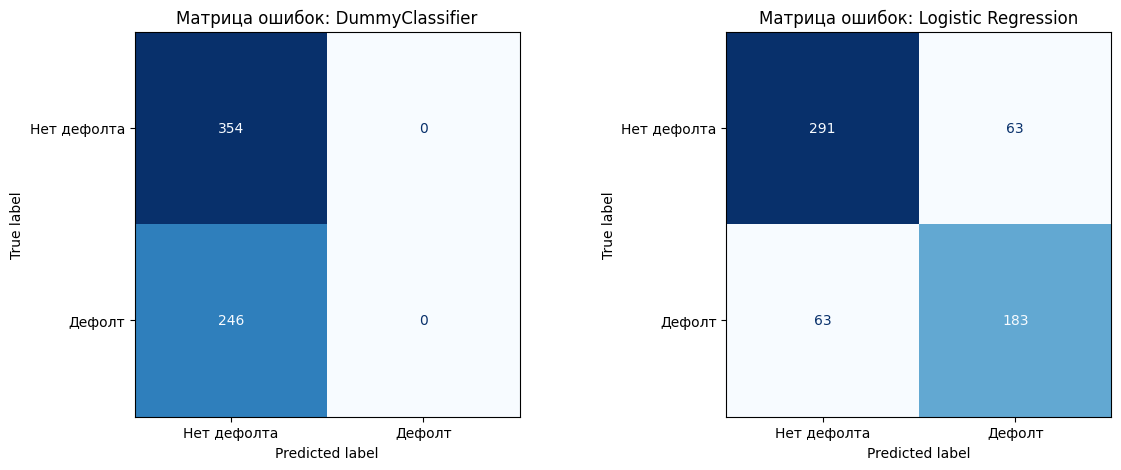

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Матрица ошибок для бейзлайна
y_baseline_pred = baseline.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_baseline_pred)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, 
                                       display_labels=['Нет дефолта', 'Дефолт'])
disp_baseline.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title('Матрица ошибок: DummyClassifier')
axes[0].grid(False)

# Матрица ошибок логистической регрессии
y_best_pred = best_model.predict(X_test)
cm_best = confusion_matrix(y_test, y_best_pred)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, 
                                   display_labels=['Нет дефолта', 'Дефолт'])
disp_best.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Матрица ошибок: Logistic Regression")
axes[1].grid(False)

fig.savefig("./figures/cm_for_baseline_and_best_logreg_model.png")

##### **Выводы**
Бейзлайн-модель (`DummyClassifier`) демонстрирует простую стратегию — всегда предсказывает наиболее частый класс - нет дефолта (0), что приводит к нулевой способности обнаруживать реальные случаи дефолта. В отличие от неё, логистическая регрессия показывает значительное улучшение по всем ключевым метрикам: `accuracy` выросла с `0.59` до `0.79` (+34%), а `ROC-AUC` увеличился с `0.500` до `0.865` (+73%).

При подборе гиперпараметра C были протестированы значения от 0.001 до 10.0. Оптимальным оказалось C=0.1 (ROC-AUC = 0.873 на валидации), при этом слишком сильная (малые C) или слишком слабая регуляризация (большие C) приводили к незначительному снижению качества (тысячные доли по оценке `ROC-AUC`).

Логистическая регрессия представляется разумным выбором для данной задачи, поскольку значительно превосходит бейзлайн. Модель успешно идентифицирует с точностью примерно 74%.